OpenMC includes a few convenience functions for generationing TRISO particle locations and placing them in a lattice. To be clear, this capability is not a stochastic geometry capability like that included in MCNP. It's also important to note that OpenMC does not use delta tracking, which would normally speed up calculations in geometries with tons of surfaces and cells. However, the computational burden can be eased by placing TRISO particles in a lattice.

In [1]:
%matplotlib inline
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import openmc
import openmc.model

Let's first start by creating materials that will be used in our TRISO particles and the background material.

In [2]:
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.5)
fuel.add_nuclide('U235', 4.6716e-02)
fuel.add_nuclide('U238', 2.8697e-01)
fuel.add_nuclide('O16',  5.0000e-01)
fuel.add_element('C', 1.6667e-01)

buff = openmc.Material(name='Buffer')
buff.set_density('g/cm3', 1.0)
buff.add_element('C', 1.0)
buff.add_s_alpha_beta('c_Graphite')

PyC1 = openmc.Material(name='PyC1')
PyC1.set_density('g/cm3', 1.9)
PyC1.add_element('C', 1.0)
PyC1.add_s_alpha_beta('c_Graphite')

PyC2 = openmc.Material(name='PyC2')
PyC2.set_density('g/cm3', 1.87)
PyC2.add_element('C', 1.0)
PyC2.add_s_alpha_beta('c_Graphite')

SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)

graphite = openmc.Material()
graphite.set_density('g/cm3', 1.1995)
graphite.add_element('C', 1.0)
graphite.add_s_alpha_beta('c_Graphite')

To actually create individual TRISO particles, we first need to create a universe that will be used within each particle. The reason we use the same universe for each TRISO particle is to reduce the total number of cells/surfaces needed which can substantially improve performance over using unique cells/surfaces in each.

In [4]:
# Create TRISO universe
spheres = [openmc.Sphere(R=r*1e-4)
           for r in [215., 315., 350., 385.]]
cells = [openmc.Cell(fill=fuel, region=-spheres[0]),
         openmc.Cell(fill=buff, region=+spheres[0] & -spheres[1]),
         openmc.Cell(fill=PyC1, region=+spheres[1] & -spheres[2]),
         openmc.Cell(fill=SiC, region=+spheres[2] & -spheres[3]),
         openmc.Cell(fill=PyC2, region=+spheres[3])]
triso_univ = openmc.Universe(cells=cells)

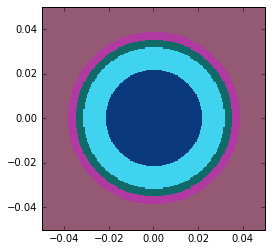

In [18]:
triso_univ.plot(width=(0.1,0.1))

Now that we have a universe that can be used for each TRISO particle, we need to randomly select locations. In this example, we will select locations at random within a 1 cm x 1 cm x 1 cm box centered at the origin with a packing fraction of 30%. Note that `pack_trisos` can handle up to the theoretical maximum of 60% (it will just be slow).

In [36]:
outer_radius = 425.*1e-4

trisos = openmc.model.pack_trisos(
    radius=outer_radius,
    fill=triso_univ,
    domain_shape='cube',
    domain_length=1,
    #packing_fraction=0.3
    n_particles=3
)

Each TRISO object actually **is** a Cell, in fact; we can look at the properties of the TRISO just as we would a cell:

In [37]:
print(trisos[0])
len(trisos)
cc=trisos[1]
print cc
triso_univ
cc.center
cc._surface
type(trisos)
type(cc)

Cell
	ID             =	5634
	Name           =	
	Fill           =	2
	Region         =	-5558
	Rotation       =	None
	Translation    =	[-0.33455672  0.31790187  0.24135378]



3

Cell
	ID             =	5635
	Name           =	
	Fill           =	2
	Region         =	-5559
	Rotation       =	None
	Translation    =	[-0.22411184 -0.0041769  -0.04621568]



Universe
	ID             =	2
	Name           =	
	Cells          =	[6, 7, 8, 9, 10]

array([-0.22411184, -0.0041769 , -0.04621568])

Surface
	ID             =	5559
	Name           =	
	Type           =	sphere
	Boundary       =	transmission
	Coefficients   
y0              =	-0.00417689531087
x0              =	-0.224111841448
R               =	0.0425
z0              =	-0.0462156757183

list

openmc.model.triso.TRISO

Let's confirm that all our TRISO particles are within the box.

In [47]:
centers = np.vstack([t.center for t in trisos])
print(centers.min(axis=0))
print(centers.max(axis=0))
centers

[-0.33455672 -0.0041769  -0.37161848]
[ 0.13870757  0.31790187  0.24135378]


array([[-0.33455672,  0.31790187,  0.24135378],
       [-0.22411184, -0.0041769 , -0.04621568],
       [ 0.13870757,  0.26418187, -0.37161848]])

We can also look at what the actual packing fraction turned out to be:

In [39]:
len(trisos)*4/3*pi*outer_radius**3

0.000964665294192916

Now that we have our TRISO particles created, we need to place them in a lattice to provide optimal tracking performance in OpenMC. We'll start by creating a box that the lattice will be placed within.

In [40]:
min_x = openmc.XPlane(x0=-0.5, boundary_type='reflective')
max_x = openmc.XPlane(x0=0.5, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.5, boundary_type='reflective')
max_y = openmc.YPlane(y0=0.5, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.5, boundary_type='reflective')
max_z = openmc.ZPlane(z0=0.5, boundary_type='reflective')
box = openmc.Cell(region=+min_x & -max_x & +min_y & -max_y & +min_z & -max_z)

Our last step is to actually create a lattice containing TRISO particles which can be done with `model.create_triso_lattice()` function. This function requires that we give it a list of TRISO particles, the lower-left coordinates of the lattice, the pitch of each lattice cell, the overall shape of the lattice (number of cells in each direction), and a background material.

In [41]:
lower_left, upper_right = box.region.bounding_box
shape = (3, 3, 3)
pitch = (upper_right - lower_left)/shape
lattice = openmc.model.create_triso_lattice(
    trisos, lower_left, pitch, shape, graphite)

Now we can set the fill of our box cell to be the lattice:

In [42]:
box.fill = lattice

Finally, let's take a look at our geometry by putting the box in a universe and plotting it. We're going to use the Fortran-side plotter since it's much faster.

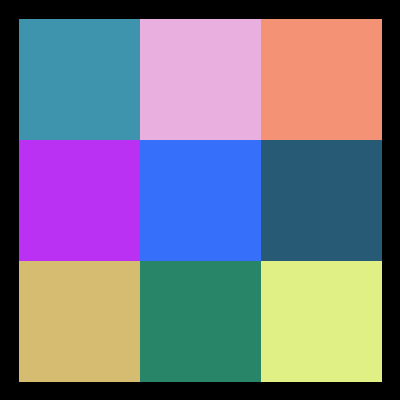

In [43]:
univ = openmc.Universe(cells=[box])

geom = openmc.Geometry(univ)
geom.export_to_xml()

mats = list(geom.get_all_materials().values())
openmc.Materials(mats).export_to_xml()

settings = openmc.Settings()
settings.run_mode = 'plot'
settings.export_to_xml()

p = openmc.Plot.from_geometry(geom)
p.width=(1.1,1.1)
p.background='black'
openmc.plot_inline(p)

If we plot the universe by material rather than by cell, we can see that the entire background is just graphite.

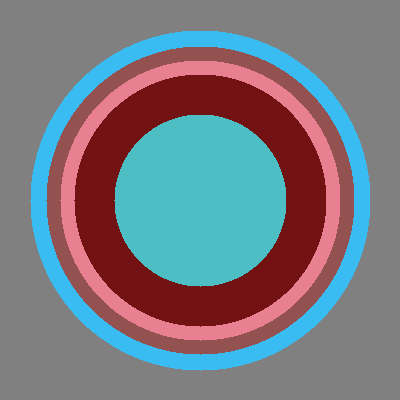

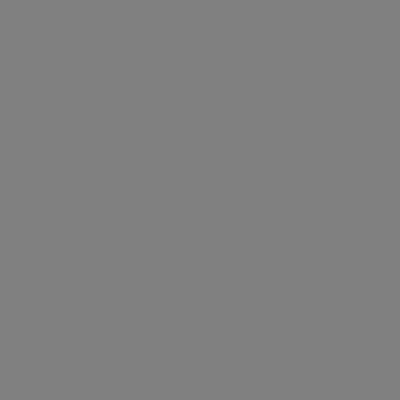

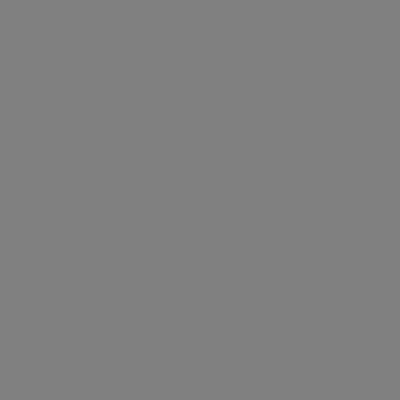

In [58]:
p.color_by = 'material'
p.colors = {graphite: 'gray'}
p.width=(0.1,0.1)
#openmc.plot_inline(p)
p.origin=centers[0]
openmc.plot_inline(p)
p.origin=(0.,0.,centers[1][2])
openmc.plot_inline(p)
p.origin=(0.,0.,centers[2][2])
openmc.plot_inline(p)

In [32]:
p

Plot
	ID             =	5
	Name           =	
	Filename       =	None
	Type           =	slice
	Basis          =	xy
	Width          =	(1.1, 1.1)
	Origin         =	[ 0.  0.  0.]
	Pixels         =	[ 0.  0.  0.]
	Color by       =	material
	Background     =	black
	Mask components=	None
	Mask background=	None
	Colors         =	{Material
	ID             =	6
	Name           =	
	Temperature    =	None
	Density        =	1.1995 [g/cm3]
	S(a,b) Tables  
	S(a,b)         =	('c_Graphite', 1.0)
	Nuclides       
	C0             =	1.0          [ao]
: 'gray'}
	Level          =	None
	Meshlines      =	None

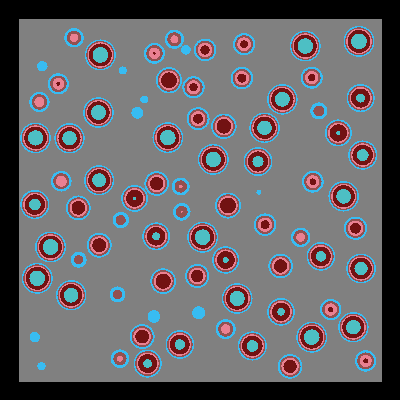